# Tracking Failure Origins

To identify the origin of a failure, one proceeds along _dependencies_: Which earlier variables could possibly have influenced the current erroneous state? And how did their values come to be? In this chapter, we show how to identify these dependencies, and how to automatically compute them.

In [1]:
from bookutils import YouTubeVideo
# YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* You should have read the [Introduction to Debugging](Intro_Debugging).
* To understand how to compute dependencies automatically, advanced knowledge of Python is required.

In [2]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Slicer import <identifier>
```

and then make use of the following features.


_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._



## Dependencies

We start with a simple program. The `middle()` function is supposed to return the "middle" number of three values `x`, `y`, and `z` – that is, the one number that neither is the minimum nor the maximum.

In [3]:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z

In most cases, `middle()` runs just fine:

In [4]:
m = middle(1, 2, 3)
m

2

In others, however, it returns the wrong value:

In [5]:
m = middle(2, 1, 3)
m

1

This is a typical debugging situation: You see a value that is erroneous; and you want to find out where it came from.

To determine the origins of a value, you need to know its _dependencies_. A variable $x$ _depends_ on the value of a variable $y$ if a change in $y$ could affect the value of $x$.

We distinguish two kinds of dependencies:

* **Data dependency**: $x$ obtains its value from a computation involving the value of $y$.
* **Control dependency**: $x$ obtains its value because of a computation involving the value of $y$.

### Excursion: Visualizing Dependencies

To illustrate our examples, we introduce a `Dependencies` class that captures dependencies between variables at specific locations.

If you are reading this in a notebook, feel free to skip this excursion and directly go to "End of Excursion", below.

#### A Class for Dependencies

`Dependencies` holds two dependency graphs. `data` holds data dependencies, `control` holds control dependencies.

In [6]:
class Dependencies(object):
    def __init__(self, data=None, control=None):
        """
Create a dependency graph from data and control. Both are dictionaries
holding _nodes_ as keys and lists of nodes as values.
Each node comes as a tuple (variable_name, location)
where `variable_name` is a string 
and `location` is a pair (code_name, lineno)
denoting a unique location in the code.
        """
        if data is None:
            data = {}
        if control is None:
            control = {}
            
        self.data = data
        self.control = control

        for var in self.data:
            self.control.setdefault(var, set())
        for var in self.control:
            self.data.setdefault(var, set())

        self.validate()

Each of the two is organized as a dictionary holding _nodes_ as keys and lists of nodes as values. Each node comes as a tuple

```python
(variable_name, location)
 ```
 
where `variable_name` is a string and `location` is a pair


```python
(code_name, lineno)
 ```
 
denoting a unique location in the code.

In [7]:
class Dependencies(Dependencies):
    def validate(self):
        """Check dependency structure."""
        assert isinstance(self.data, dict)
        assert isinstance(self.control, dict)
        
        for node in (self.data.keys()) | set(self.control.keys()):
            var_name, location = node
            assert isinstance(var_name, str)
            func_name, lineno = location
            assert isinstance(func_name, str)
            assert isinstance(lineno, int)

The `source()` method returns the source code for a given node.

In [8]:
import inspect

In [9]:
class Dependencies(Dependencies):
    def source(self, node):
        """Return the source code for a given node."""
        (name, location) = node
        code_name, lineno = location
        if code_name not in globals():
            return ''

        fun = globals()[code_name]
        source_lines, first_lineno = inspect.getsourcelines(fun)

        try:
            line = source_lines[lineno - first_lineno].strip()
        except IndexError:
            line = ''

        return line

In [10]:
test_deps = Dependencies()
test_deps.source(('z', ('middle', 1)))

'def middle(x, y, z):'

#### Drawing Dependencies

Both data and control form a graph between nodes, and cam be visualized as such. We use the `graphviz` package for creating such visualizations.

In [11]:
from graphviz import Digraph, nohtml

`make_graph()` sets the basic graph attributes.

In [12]:
import html

In [13]:
class Dependencies(Dependencies):
    NODE_COLOR = 'peachpuff'
    FONT_NAME = 'Fira Mono'

    def make_graph(self, name="dependencies", comment="Dependencies"):
        return Digraph(name=name, comment=comment, 
            graph_attr={
            },
            node_attr={
                'style': 'filled',
                'shape': 'box',
                'fillcolor': self.NODE_COLOR,
                'fontname': self.FONT_NAME
            },
            edge_attr={
                'fontname': self.FONT_NAME
            })

`graph()` returns a graph visualization.

In [14]:
class Dependencies(Dependencies):
    def graph(self):
        """Draw dependencies."""
        self.validate()

        g = self.make_graph()
        self.draw_dependencies(g)
        self.add_hierarchy(g)
        return g

The main part of graph drawing takes place in two methods, `draw_dependencies()` and `add_hierarchy()`.

`draw_dependencies()` processes through the graph, adding nodes and edges from the dependencies.

In [15]:
class Dependencies(Dependencies):
    def all_vars(self):
        all_vars = set()
        for var in self.data:
            all_vars.add(var)
            for source in self.data[var]:
                all_vars.add(source)

        for var in self.control:
            all_vars.add(var)
            for source in self.control[var]:
                all_vars.add(source)

        return all_vars

In [16]:
class Dependencies(Dependencies):
    def draw_dependencies(self, g):
        for var in self.all_vars():
            g.node(self.id(var),
                   label=self.label(var),
                   tooltip=self.tooltip(var))

            if var in self.data:
                for source in self.data[var]:
                    g.edge(self.id(source), self.id(var))

            if var in self.control:
                for source in self.control[var]:
                    g.edge(self.id(source), self.id(var),
                           style='dashed', color='grey')

`draw_dependencies()` makes use of a few helper functions.

In [17]:
class Dependencies(Dependencies):
    def id(self, var):
        """Return a unique ID for VAR."""
        id = ""
        # Avoid non-identifier characters
        for c in repr(var):
            if c.isalnum() or c == '_':
                id += c
            if c == ':' or c == ',':
                id += '_'
        return id

    def label(self, var):
        """Render node VAR using HTML style."""
        (name, location) = var
        source = self.source(var)

        title = html.escape(name)
        if name.startswith('<'):
            title = f'<I>{title}</I>'

        label = f'<B>{title}</B>'
        if source:
            label += (f'<FONT POINT-SIZE="9.0"><BR/><BR/>'
                    f'{html.escape(source)}'
                    f'</FONT>')
        label = f'<{label}>'
        return label

    def tooltip(self, var):
        """Return a tooltip for node VAR."""
        (name, location) = var
        code_name, lineno = location
        return f"{code_name}:{lineno}"

In the second part of graph drawing, `add_hierarchy()` adds invisible edges to ensure that nodes with lower line numbers are drawn above nodes with higher line numbers.

In [18]:
class Dependencies(Dependencies):
    def add_hierarchy(self, g):
        """Add invisible edges for a proper hierarchy."""
        code_names = self.all_codes()
        for code_name in code_names:
            last_var = None
            last_lineno = 0
            for (lineno, var) in code_names[code_name]:
                if last_var is not None and lineno > last_lineno:
                    g.edge(self.id(last_var),
                           self.id(var),
                           style='invis')

                last_var = var
                last_lineno = lineno

        return g

In [19]:
class Dependencies(Dependencies):
    def all_codes(self):
        code_names = {}
        for var in self.all_vars():
            (name, location) = var
            code_name, lineno = location
            if code_name not in code_names:
                code_names[code_name] = []
            code_names[code_name].append((lineno, var))

        for code_name in code_names:
            code_names[code_name].sort()

        return code_names

Here comes the graph in all its glory:

In [20]:
def middle_deps():
    return Dependencies({('z', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('x', ('middle', 1)): set(), ('<test>', ('middle', 2)): {('y', ('middle', 1)), ('z', ('middle', 1))}, ('<test>', ('middle', 3)): {('y', ('middle', 1)), ('x', ('middle', 1))}, ('<test>', ('middle', 5)): {('z', ('middle', 1)), ('x', ('middle', 1))}, ('<middle() return value>', ('middle', 6)): {('y', ('middle', 1))}}, {('z', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('x', ('middle', 1)): set(), ('<test>', ('middle', 2)): set(), ('<test>', ('middle', 3)): {('<test>', ('middle', 2))}, ('<test>', ('middle', 5)): {('<test>', ('middle', 3))}, ('<middle() return value>', ('middle', 6)): {('<test>', ('middle', 5))}})

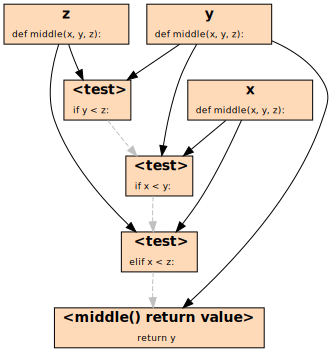

In [21]:
middle_deps().graph()

#### Slices

The method `backward_slice(*items, mode='cd')` returns a subset of dependencies, following dependencies backward from the given `items`. The extra parameter `mode` controls which dependencies are to be included:

* **`d`** = data dependencies
* **`c`** = control dependencies

In [22]:
class Dependencies(Dependencies):
    def expand_items(self, items):
        all_items = []
        for item in items:
            if isinstance(item, str):
                for var in self.all_vars():
                    (name, location) = var
                    if name == item:
                        all_items.append(var)
            else:
                all_items.append(item)

        return all_items

    def backward_slice(self, *items, mode="cd", depth=-1):
        """Create a backward slice from nodes ITEMS."""
        data = {}
        control = {}
        queue = self.expand_items(items)
        seen = set()

        while len(queue) > 0 and depth != 0:
            var = queue[0]
            queue = queue[1:]
            seen.add(var)

            if 'd' in mode:
                # Follow data dependencies
                data[var] = self.data[var]
                for next_var in data[var]:
                    if next_var not in seen:
                        queue.append(next_var)
            else:
                data[var] = set()

            if 'c' in mode:
                # Follow control dependencies
                control[var] = self.control[var]
                for next_var in control[var]:
                    if next_var not in seen:
                        queue.append(next_var)
            else:
                control[var] = set()
                
            depth = depth - 1

        return Dependencies(data, control)

### End of Excursion

### Data Dependencies

Here is an example of a data dependency in our `middle()` program. The value `y` returned by `middle()` comes from the value `y` as originally passed as argument. We use arrows $x \leftarrow y$ to indicate that a variable $x$ depends on an earlier variable $y$:

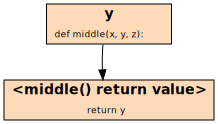

In [23]:
# ignore
middle_deps().backward_slice('<middle() return value>', mode='d').graph()

Here, we can see that the value `y` in the return statement is data dependent on the value of `y` as passed to `middle()`. An alternate interpretation of this graph is a *data flow*: The value of `y` in the upper node _flows_ into the value of `y` in the lower node.

Since we consider the values of variables at specific locations in the program, such data dependencies can also be interpreted as dependencies between _statements_ – the above `return` statement thus is data dependent on the initialization of `y` in the upper node.

### Control Dependencies

Here is an example of a control dependency. The execution of the above `return` statement is controlled by the earlier test `x < z`. We use grey dashed lines to indicate control dependencies:

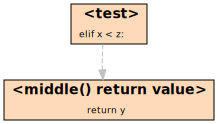

In [24]:
# ignore
middle_deps().backward_slice('<middle() return value>', mode='c', depth=1).graph()

This test in turn is controlled by earlier tests, so the full chain of control dependencies looks like this:

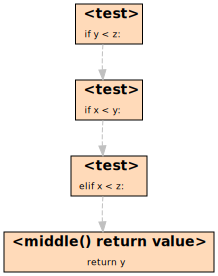

In [25]:
# ignore
middle_deps().backward_slice('<middle() return value>', mode='c').graph()

### Dependency Graphs

As the above `<test>` values (and their statements) are in turn also dependent on earlier data, namely the `x`, `y`, and `z` values as originally passed. We can draw all data and control dependencies in a single graph, called a _program dependency graph_:

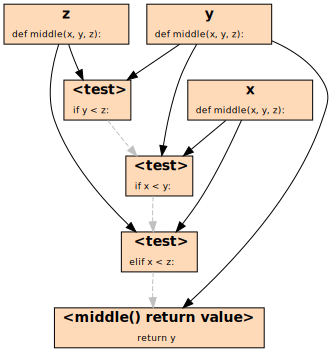

In [26]:
# ignore
middle_deps().graph()

This graph now gives us an idea on how to proceed to track the origins of the `middle()` return value at the bottom. Its value can come from any of the dependences – namely the initialization of `y` at the function call, or from the `<test>` that controls it. This test in turn depends on `x` and `z` and their associated statements, which we now can check one after the other.

Note that all these dependencies in the graph are _dynamic_ dependencies – that is, they refer to statements actually evaluated in the run at hand, as well as the decisions made in that very run. There also are _static_ dependency graphs coming from static analysis of the code; but for debugging, _dynamic_ dependencies specific to the failing run are more useful.

### Showing Dependencies with Code

While a graph gives us a representation about which possible data and control flows to track, integrating dependencies with actual program code results in a compact representation that is easy to reason about.

#### Excursion: Listing Dependencies

To show dependencies as text, we introduce a method `format_var()` that shows a single node (a variable) as text. By default, a node is referenced as

```python
NAME (FUNCTION:LINENO)
```

However, within a given function, it makes no sense to re-state the function name again and again, so we have a shorthand

```python
NAME (LINENO)
```

to state a dependency to variable `NAME` in line `LINENO`.

In [27]:
class Dependencies(Dependencies):
    def format_var(self, var, current_location=None):
        """Return string for VAR in CURRENT_LOCATION."""
        name, location = var
        location_name, lineno = location
        if location_name != current_location:
            return f"{name} ({location_name}:{lineno})"
        else:
            return f"{name} ({lineno})"

`format_var()` is used extensively in this string representation of dependencies, listing all nodes and their data (`<=`) and control (`<-`) dependencies.

In [28]:
class Dependencies(Dependencies):
    def __str__(self):
        self.validate()

        out = ""
        for code_name in self.all_codes():
            if out != "":
                out += "\n"
            out += f"{code_name}():\n"

            all_vars = list(set(self.data.keys()) | set(self.control.keys()))
            all_vars.sort(key=lambda var: var[1][1])

            for var in all_vars:
                (name, location) = var
                var_code, var_lineno = location
                if var_code != code_name:
                    continue

                all_deps = ""
                for (source, arrow) in [(self.data, "<="), (self.control, "<-")]:
                    deps = ""
                    for data_dep in source[var]:
                        if deps == "":
                            deps = f" {arrow} "
                        else:
                            deps += ", "
                        deps += self.format_var(data_dep, code_name)

                    if deps != "":
                        if all_deps != "":
                            all_deps += ";"
                        all_deps += deps

                if all_deps == "":
                    continue

                out += ("    " + 
                        self.format_var(var, code_name) +
                        all_deps + "\n")

        return out

    def __repr__(self):
        # Useful for saving and restoring values
        return f"Dependencies({self.data}, {self.control})"

Here is a compact string representation of dependencies. We see how the (last) `middle() return value` has a data dependency to `y` in Line 1, and to the `<test>` in Line 5.

In [29]:
print(middle_deps())

middle():
    <test> (2) <= z (1), y (1)
    <test> (3) <= x (1), y (1); <- <test> (2)
    <test> (5) <= x (1), z (1); <- <test> (3)
    <middle() return value> (6) <= y (1); <- <test> (5)



An even more useful representation comes when integrating these dependencies as comments into the code. The method `code(item)` lists the given (function) item, including its dependencies.

In [30]:
from bookutils import print_content

In [31]:
class Dependencies(Dependencies):
    def code(self, item, mode='cd'):
        """List ITEM on standard output, including dependencies as comments."""
        all_vars = self.all_vars()
        slice_locations = set(location for name, location in all_vars)

        source_lines, first_lineno = inspect.getsourcelines(item)

        n = first_lineno
        for line in source_lines:
            line_location = (item.__name__, n)
            if line_location in slice_locations:
                prefix = "* "
            else:
                prefix = "  "

            print(f"{prefix}{n:4} ", end="")

            comment = ""
            for (mode_control, source, arrow) in [
                ('d', self.data, '<='),
                ('c', self.control, '<-')
            ]:
                if mode_control not in mode:
                    continue

                deps = ""
                for var in source:
                    name, location = var
                    if location == line_location:
                        for dep_var in source[var]:
                            if deps == "":
                                deps = arrow + " "
                            else:
                                deps += ", "
                            deps += self.format_var(dep_var, item.__name__)

                if deps != "":
                    if comment != "":
                        comment += "; "
                    comment += deps

            if comment != "":
                line = line.rstrip() + "  # " + comment

            print_content(line.rstrip(), '.py')
            print()
            n += 1

#### End of Excursion

The following listing shows such an integration. For each executed line (`*`), we see its data (`<=`) and control (`<-`) dependencies, listing the associated variables and line numbers. The comment

```python
# <= y (1); <- <test> (5)
```

for Line 6, for instance, states that the return value is data dependent on the value of `y` in Line 1, and control dependent on the test in Line 5.

Again, one can easily follow these dependencies back to track where a value came from (data dependencies) and why a statement was executed (control dependency).

In [32]:
# ignore
middle_deps().code(middle)

*    1 def middle(x, y, z):
*    2     if y < z:  # <= z (1), y (1)
*    3         if x < y:  # <= x (1), y (1); <- <test> (2)
     4             return y
*    5         elif x < z:  # <= x (1), z (1); <- <test> (3)
*    6             return y  # <= y (1); <- <test> (5)
     7     else:
     8         if x > y:
     9             return y
    10         elif x > z:
    11             return x
    12     return z


One important aspect of dependencies is that they not only point to specific sources and causes of failures – but that they also _rule out_ parts of program and state as failures. 

* In the above code, Lines 8 and later have no influence on the output, simply because they were not executed.
* Furthermore, we see that we can start our investigation with Line 6, because that is the last one executed.
* The data dependencies tell us that no statement has interfered with the value of `y` between the function call and its return.
* Hence, the error must be in the conditions and the final `return` statement.

With this in mind, recall that our original invocation was `middle(2, 1, 3)`. Why and how is the above code wrong?

In [33]:
from bookutils import quiz

In [34]:
quiz("Which of the following <samp>middle()</samp> code lines should be fixed?",
    [
        "Line 2: <samp>if y < z:</samp>",
        "Line 3: <samp>if x < y:</samp>",
        "Line 5: <samp>elif x < z:</samp>",
        "Line 6: <samp>return z</samp>",
    ], (1 ** 0 + 1 ** 1) ** (1 ** 2 + 1 ** 3))

Indeed, from the controlling conditions, we see that `y < z`, `x >= y`, and `x < z` all hold. Hence, `y <= x < z` holds, and it is `x`, not `y`, that should be returned.

## Tracking Techniques

The question of "Where does this value come from?" is fundamental for debugging. When programmers read code during debugging, they scan it for potential data and control dependencies. This can be a tedious experience, notably if the data and control flow is spread across multiple separate locations, possibly even in different modules.

In this chapter, we thus investigate means to _determine such dependencies_ automatically – by _collecting_ them during program execution. This means that for every variable, we need to keep track of its _origins_ – where it obtained its value, and which tests controlled its assignments.

### Wrapping Data Objects

There are multiple ways to track such origins. One way is to _wrap_ each value in a class that stores both a value and the origin of the value. If a variable `x` is initialized to zero in Line 3, for instance, we could store it as
```
x = (value=0, origin=<Line 3>)
```
and if it is copied in, say, Line 5 to another variable `y`, we could store this as
```
y = (value=0, origin=<Line 3, Line 5>)
```
Such a scheme would allow us to track origins and dependencies right within the variable.

In a language like Python, it is actually possibly to subclass from basic types. Here's how we create a `MyInt` subclass of `int`:

In [35]:
class MyInt(int):
    def __new__(cls, value, *args, **kwargs):
        return super(cls, cls).__new__(cls, value)

    def __repr__(self):
        return f"{int(self)}"

In [36]:
x = MyInt(5)

We can access `x` just like any integer:

In [37]:
x, x + 1

(5, 6)

However, we can also add extra attributes to it:

In [38]:
x.origin = "Line 5"

In [39]:
x.origin

'Line 5'

Such a "wrapping" scheme has the advantage of _leaving program code untouched_ – simply pass "wrapped" objects instead of the original values. However, it also has a number of drawbacks.

* First, we must make sure that the "wrapper" objects are still compatible with the original values – notably by converting them back whenever needed. (What happens if an internal Python function expects an `int` and gets a `MyInt` instead?)
* Second, we have to make sure that origins do not get lost during computations – which involves overloading operators such as `+`, `-`, `*`, and so on. (Right now, `MyInt(1) + 1` gives us an `int` object, not a `MyInt`.)
* Third, we have to do this for _all_ data types of a language, which is pretty tedious.
* Fourth and last, however, we want to track whenever a value is assigned to another variable. Python has no support for this, and thus our dependencies will necessarily be incomplete.

### Wrapping Data Accesses

An alternate way of tracking origins is to _instrument_ the source code such that all _data read and write operations are tracked_. That is, the original data stays unchanged, but we change the code instead.

In essence, for every occurrence of a variable `x` being _read_, we replace it with

```python
_data.get('x', x)  # returns x
```

and for every occurrence of a value being _written_ to `x`, we replace the value with

```python
_data.set('x', value)  # returns value
```

and let the `_data` object track these reads and writes.

Hence, an assignment such as 

```python
a = b + c
```

would get rewritten to

```python
a = _data.set('a', _data.get('b', b) + _data.get('c', c))
```

and with every access to `_data`, we would track 

1. the current _location_ in the code, and 
2. whether the respective variable was read or written.

For the above statement, we could deduce that `b` and `c` were read, and `a` was written – which makes `a` data dependent on `b` and `c`.

The advantage of such instrumentation is that it works with _arbitrary objects_ (in Python, that is) – we do not case whether `a`, `b`, and `c` would be integers, floats, strings, lists. or any other type for which `+` would be defined. Also, the code semantics remain entirely unchanged.

The disadvantage, however, is that it takes a bit of effort to exactly separate reads and writes into individual groups, and that a number of language features have to be handled separately. This is what we do in the remainder of this chapter.

## A Data Tracker

To implement `_data` accesses as shown above, we introduce the `DataTracker` class. As its name suggests, it keeps track of variables being read and written, and provides methods to determine the code location where this tool place.

In [40]:
class DataTracker(object):
    def __init__(self, log=False):
        """Initialize. If LOG is set, turn on logging."""
        self.log = log

The method `caller_frame()` walks up the current call stack until it finds a method or function that is not part of `DataTracker`. `caller_location()` returns its location.

In [41]:
class DataTracker(DataTracker):
    def caller_frame(self):
        """Return the frame of the caller."""
        frame = inspect.currentframe()
        while ('self' in frame.f_locals and 
               isinstance(frame.f_locals['self'], self.__class__)):
               frame = frame.f_back
        return frame

    def caller_location(self):
        """Return the location (code name, lineno) of the caller."""
        frame = self.caller_frame()
        if frame.f_code.co_name in globals():
            return frame.f_code.co_name, frame.f_lineno
        else:
            return frame.f_code.co_filename, frame.f_lineno

`set()` is invoked when a variable is set, as in

```python
pi = _data.set('pi', 3.1415)
```

By default, we simply log the access.

In [42]:
class DataTracker(DataTracker):
    def set(self, name, value):
        """Track setting NAME to VALUE."""
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: setting {name}")

        return value

`get()` is invoked when a variable is retrieved, as in

```python
print(_data.get('pi', pi))
```
By default, we simply log the access.

In [43]:
class DataTracker(DataTracker):
    def get(self, name, value):
        """Track getting VALUE from NAME."""

        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: getting {name}")
            
        return value

In [44]:
class DataTracker(DataTracker):
    def __repr__(self):
        return super().__repr__()

Here's an example of a logging `DataTracker`:

In [45]:
_test_data = DataTracker(log=True)
x = _test_data.set('x', 1)

<ipython-input-45-6b3e9b941320>:2: setting x


In [46]:
_test_data.get('x', x)

<ipython-input-46-06cdcf804da2>:1: getting x


1

## Instrumenting Source Code

How do we transform source code such that read and write accesses to variables would be automatically rewritten?  To this end, we inspect the internal representation of source code, namely the _abstract syntax trees_ (ASTs). An AST represents the code as a tree, with specific node types for each syntactical element.

In [47]:
import ast
import astor

Here is the tree representation for our `middle()` function. It starts with a `FunctionDef` node at the top (with the name `"middle"` and the three arguments `x`, `y`, `z` as children), followed by a subtree for each of the `If` statements, each of which contains a branch for when their condition evaluates to`True` and a branch for when their condition evaluates to `False`.

In [48]:
from bookutils import rich_output

In [49]:
if rich_output():
    from showast import show_ast
else:
    def show_ast(tree):
        ast.dump(tree)

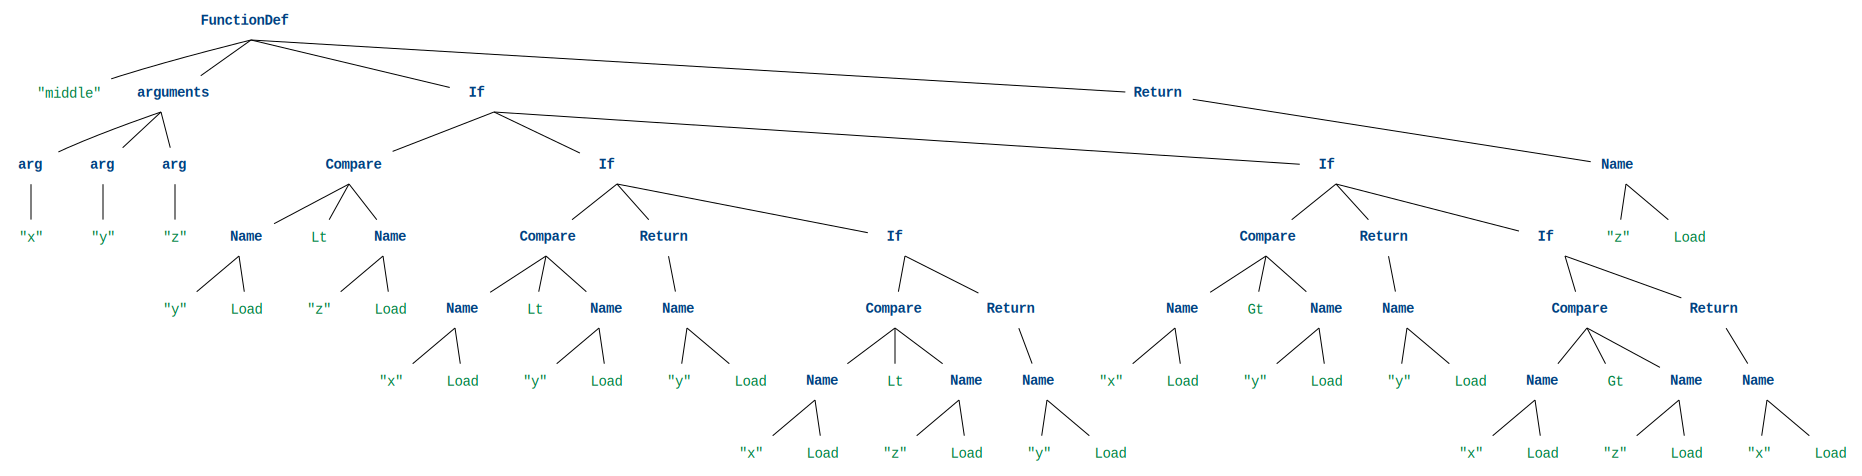

In [50]:
middle_tree = ast.parse(inspect.getsource(middle))
show_ast(middle_tree)

At the very bottom of the tree, you can see a number of `Name` nodes, referring individual variables. These are the ones we want to transform.

### Tracking Variable Access

Our goal is to _traverse_ the tree, identify all `Name` nodes, and convert them to respective `_data` accesses.
To this end, we manipulate the AST through the Python modules `ast` and `astor`. The [official Python `ast` reference](http://docs.python.org/3/library/ast) is complete, but a bit brief; the documentation ["Green Tree Snakes - the missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/) provides an excellent introduction.

The Python `ast` class provides a class `NodeTransformer` that allows such transformations. Subclassing from it, we provide a method `visit_Name()` that will be invoked for all `Name` nodes – and replace it by a new subtree from `make_get_data()`:

In [51]:
from ast import NodeTransformer

In [52]:
DATA_TRACKER = '_data'

In [53]:
class TrackGetTransformer(NodeTransformer):
    def visit_Name(self, node):
        self.generic_visit(node)

        if node.id in dir(__builtins__):
            # Do not change built-in names
            return node
        
        if node.id == DATA_TRACKER:
            # Do not change own accesses
            return node
        
        if isinstance(node.ctx, Store):
            # Do not change stores
            return node

        return make_get_data(node.id)

Our function `make_get_data(id, method)` returns a new subtree equivalent to the Python code `_data.method('id', id)`.

In [54]:
from ast import Module, Subscript, Name, Load, Store, \
    Assign, AugAssign, Attribute, Constant, \
    With, withitem, Return, Index, Str, Call, Expr

In [55]:
def make_get_data(id, method='get'):
    return Call(func=Attribute(value=Name(id=DATA_TRACKER, ctx=Load()), 
                               attr=method, ctx=Load()),
                args=[Str(s=id), Name(id=id, ctx=Load())],
                keywords=[])

This is the tree that `make_get_data()` produces:

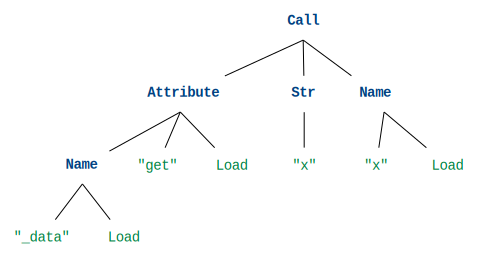

In [56]:
show_ast(Module(body=[make_get_data("x")]))

How do we know that this is a correct subtree? We can carefully read the [official Python `ast` reference](http://docs.python.org/3/library/ast) and then proceed by trial and error (and apply [delta debugging](DeltaDebugger.ipynb) to determine error causes). Or – pro tip! – we can simply take a piece of Python code, parse it and use `ast.dump()` to print out how to construct the resulting AST:

In [57]:
print(ast.dump(ast.parse("_data.get('x', x)")))

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='_data', ctx=Load()), attr='get', ctx=Load()), args=[Str(s='x'), Name(id='x', ctx=Load())], keywords=[]))])


If you compare the above output with the code of `make_get_data()`, above, you will find out where the source of `make_get_data()` comes from.

Let us put `TrackGetTransformer` to action. Its `visit()` method calls `visit_Name()`, which then in turn transforms the `Name` nodes as we want it. This happens in place.

In [58]:
TrackGetTransformer().visit(middle_tree);

To see the effect of our transformations, we introduce a method `dump_tree()` which outputs the tree – and also compiles it to check for any inconsistencies.

In [59]:
def dump_tree(tree):
    print(astor.to_source(tree))
    ast.fix_missing_locations(tree)  # Must run this before compiling
    _ = compile(tree, '<string>', 'exec')

We see that our transformer has properly replaced all 

In [60]:
dump_tree(middle_tree)

def middle(x, y, z):
    if _data.get('y', y) < _data.get('z', z):
        if _data.get('x', x) < _data.get('y', y):
            return _data.get('y', y)
        elif _data.get('x', x) < _data.get('z', z):
            return _data.get('y', y)
    elif _data.get('x', x) > _data.get('y', y):
        return _data.get('y', y)
    elif _data.get('x', x) > _data.get('z', z):
        return _data.get('x', x)
    return _data.get('z', z)



Let us now execute this code together with the `DataTracker()` class we previously introduced. The class `DataTrackerTester()` takes a (transformed) tree and a function. Using it as

```python
with DataTrackerTester(tree, func):
    func(...)
```

first executes the code in _tree_ (possibly instrumenting `func`) and then the `with` body. At the end, `func` is restored to its previous (non-instrumented) version.

In [61]:
class DataTrackerTester(object):
    def __init__(self, tree, func, log=True):
        self.code = compile(tree, '<string>', 'exec')
        self.func = func
        self.log = log
        
    def make_data_tracker(self):
        return DataTracker(log=self.log)

    def __enter__(self):
        """Rewrite function"""
        tracker = self.make_data_tracker()
        globals()[DATA_TRACKER] = tracker
        exec(self.code, globals())
        return tracker

    def __exit__(self, exc_type, exc_value, traceback):
        """Restore function"""
        globals()[self.func.__name__] = self.func
        del globals()[DATA_TRACKER]

Here is our `middle()` function:

In [62]:
print_content(inspect.getsource(middle), '.py', start_line_number=1)

 1  def middle(x, y, z):
 2      if y < z:
 3          if x < y:
 4              return y
 5          elif x < z:
 6              return y
 7      else:
 8          if x > y:
 9              return y
10          elif x > z:
11              return x
12      return z

And here is our instrumented `middle_tree` executed with a `DataTracker` object. We see how the `middle()` tests access one argument after another.

In [63]:
with DataTrackerTester(middle_tree, middle):
    middle(2, 1, 3)

middle:2: getting y
middle:2: getting z
middle:3: getting x
middle:3: getting y
middle:5: getting x
middle:5: getting z
middle:6: getting y


After `DataTrackerTester` is done, `middle` is reverted to its non-instrumented version:

In [64]:
middle(2, 1, 3)

1

For a complete picture of what happens during executions, we implement a number of additional code transformers.

For each assignment statement `x = y`, we change it to `x = _data.set('x', y)`. This allows to __track assignments__.

### Excursion: Tracking Assignments

For the remaining transformers, we follow the same steps as for `TrackGetTransformer`, except that our `visit_...()` methods focus on different nodes, and return different subtrees. Here, we focus on assignment nodes.

We want to transform assignments `x = value` into `_data.set('x', value)`. Using `ast.dump()`, we reveal what the corresponding syntax tree has to look like:

In [65]:
print(ast.dump(ast.parse("_data.set('x', value)")))

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='_data', ctx=Load()), attr='set', ctx=Load()), args=[Str(s='x'), Name(id='value', ctx=Load())], keywords=[]))])


Using this structure, we can write a function `make_set_data()` which constructs such a subtree.

In [66]:
def make_set_data(id, value, method='set'):
    """Construct a subtree _data.METHOD('ID', VALUE)"""
    return Call(func=Attribute(value=Name(id=DATA_TRACKER, ctx=Load()), 
                               attr=method, ctx=Load()), 
                args=[Str(s=id), value], 
                keywords=[])

Here's our transformer for regular assignments:

In [67]:
class TrackSetTransformer(NodeTransformer):
    def visit_Assign(self, node):
        value = astor.to_source(node.value)
        if value.startswith(DATA_TRACKER):
            return node  # Do not apply twice
        
        id = astor.to_source(node).split(' = ')[0].strip()
        node.value = make_set_data(id, node.value)
        return node

The special form of "augmented assign" needs special treatment. We change statements of the form `x += y` to `x += _data.augment('x', y)`.

In [68]:
class TrackSetTransformer(TrackSetTransformer):
    def visit_AugAssign(self, node):
        value = astor.to_source(node.value)
        if value.startswith(DATA_TRACKER):
            return node  # Do not apply twice
        
        id = astor.to_source(node.target).strip()
        node.value = make_set_data(id, node.value, method='augment')
        return node

The corresponding `augment()` method uses a combination of `set()` and `get()` to reflect the semantics.

In [69]:
class DataTracker(DataTracker):
    def augment(self, name, value):
        """Track augmenting NAME with VALUE."""
        self.set(name, self.get(name, value))
        return value

Here's both of these transformers in action. Our original function has a number of assignments:

In [70]:
def assign_test(x):
    forty_two = 42
    a, b, c = 1, 2, 3
    c[x] = 47
    foo *= bar + 1

In [71]:
assign_tree = ast.parse(inspect.getsource(assign_test))

In [72]:
TrackSetTransformer().visit(assign_tree)
dump_tree(assign_tree)

def assign_test(x):
    forty_two = _data.set('forty_two', 42)
    a, b, c = _data.set('a, b, c', (1, 2, 3))
    c[x] = _data.set('c[x]', 47)
    foo *= _data.augment('foo', bar + 1)



Note that we have no special support for composite assignment targets, such as `a, b, c` or `c[x]` in the example above. From the standpoint of the data tracker, these make separate named variables.

If we later apply our transformer for data accesses, we can see that we track all variable reads and writes.

In [73]:
TrackGetTransformer().visit(assign_tree)
dump_tree(assign_tree)

def assign_test(x):
    forty_two = _data.set('forty_two', 42)
    a, b, c = _data.set('a, b, c', (1, 2, 3))
    _data.get('c', c)[_data.get('x', x)] = _data.set('c[x]', 47)
    foo *= _data.augment('foo', _data.get('bar', bar) + 1)



### End of Excursion

Each return statement `return x` is transformed to `return _data.set('<return_value>', x)`. This allows to __track return values__.

### Excursion: Tracking Return Values

Our `TrackReturnTransformer` also makes use of `make_set_data()`.

In [74]:
class TrackReturnTransformer(NodeTransformer):
    def __init__(self):
        self.function_name = None
        super().__init__()

    def visit_FunctionDef(self, node):
        outer_name = self.function_name
        self.function_name = node.name  # Save current name
        self.generic_visit(node)
        self.function_name = outer_name
        return node

    def return_value(self):
        if self.function_name is None:
            return "<return value>"
        else:
            return f"<{self.function_name}() return value>"

    def visit_Return(self, node):
        if node.value is not None:
            value = astor.to_source(node.value)
            if not value.startswith(DATA_TRACKER + '.set'):
                node.value = make_set_data(self.return_value(), node.value)
        return node

This is the effect of `TrackReturnTransformer`. We see that all return values are saved, and thus all locations of the corresponding return statements are tracked.

In [75]:
TrackReturnTransformer().visit(middle_tree)
dump_tree(middle_tree)

def middle(x, y, z):
    if _data.get('y', y) < _data.get('z', z):
        if _data.get('x', x) < _data.get('y', y):
            return _data.set('<middle() return value>', _data.get('y', y))
        elif _data.get('x', x) < _data.get('z', z):
            return _data.set('<middle() return value>', _data.get('y', y))
    elif _data.get('x', x) > _data.get('y', y):
        return _data.set('<middle() return value>', _data.get('y', y))
    elif _data.get('x', x) > _data.get('z', z):
        return _data.set('<middle() return value>', _data.get('x', x))
    return _data.set('<middle() return value>', _data.get('z', z))



In [76]:
with DataTrackerTester(middle_tree, middle):
    middle(2, 1, 3)

middle:2: getting y
middle:2: getting z
middle:3: getting x
middle:3: getting y
middle:5: getting x
middle:5: getting z
middle:6: getting y
middle:6: setting <middle() return value>


### End of Excursion

To track __control dependencies__, for every block controlled by an `if`, `while`, or `for`:

1. We wrap their tests in a `_data.test()` wrapper. This allows us to assign pseudo-variables like `<test>` which hold the conditions.
2. We wrap their controlled blocks in a `with` statement. This allows us to track the variables read right before the `with` (= the controlling variables), and to restore the current controlling variables when the block is left.

A statement

```python
if cond:
    body
```

thus becomes

```python
if _data.test(cond):
    with _data:
        body
```

### Excursion: Tracking Control

To modify control statements, we traverse the tree, looking for `If` nodes:

In [77]:
class TrackControlTransformer(NodeTransformer):
    def visit_If(self, node):
        self.generic_visit(node)
        node.test = self.make_test(node.test)
        node.body = self.make_with(node.body)
        node.orelse = self.make_with(node.orelse)
        return node

The subtrees come from helper functions `make_with()` and `make_test()`. Again, all these subtrees are obtained via `ast.dump()`.

In [78]:
class TrackControlTransformer(TrackControlTransformer):
    def make_with(self, block):
        """Create a subtree 'with _data: BLOCK'"""
        if len(block) == 0:
            return []
        
        block_as_text = astor.to_source(block[0])
        if block_as_text.startswith('with ' + DATA_TRACKER):
            return block  # Do not apply twice

        return [With(
            items=[
                withitem(
                    context_expr=Name(id=DATA_TRACKER, ctx=Load()),
                    optional_vars=None)
            ],
            body=block
        )]

In [79]:
class TrackControlTransformer(TrackControlTransformer):
    def make_test(self, test):
        test_as_text = astor.to_source(test)
        if test_as_text.startswith(DATA_TRACKER + '.test'):
            return test

        return Call(func=Attribute(value=Name(id=DATA_TRACKER, ctx=Load()),
                                   attr='test',
                                   ctx=Load()),
                     args=[test],
                     keywords=[])

`while` loops are handled just like `if` constructs.

In [80]:
class TrackControlTransformer(TrackControlTransformer):
    def visit_While(self, node):
        self.generic_visit(node)
        node.test = self.make_test(node.test)
        node.body = self.make_with(node.body)
        node.orelse = self.make_with(node.orelse)
        return node

`for` loops gets a different treatment, as there is no condition that would control the body. Still, we ensure that setting the iterator variable is properly tracked.

In [81]:
class TrackControlTransformer(TrackControlTransformer):
    def visit_For(self, node):
        self.generic_visit(node)
        id = astor.to_source(node.target).strip()
        node.iter = make_set_data(id, node.iter)

        # Uncomment if you want iterators to control their bodies
        # node.body = self.make_with(node.body)
        # node.orelse = self.make_with(node.orelse)
        return node

Here is the effect of `TrackControlTransformer`:

In [82]:
TrackControlTransformer().visit(middle_tree)
dump_tree(middle_tree)

def middle(x, y, z):
    if _data.test(_data.get('y', y) < _data.get('z', z)):
        with _data:
            if _data.test(_data.get('x', x) < _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_data.get('x', x) < _data.get('z', z)):
                        with _data:
                            return _data.set('<middle() return value>',
                                _data.get('y', y))
    else:
        with _data:
            if _data.test(_data.get('x', x) > _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_data.get('x', x) > _data.get('z', z)):
                        with _data:
                            retu

We extend `DataTracker` to also log these events:

In [83]:
class DataTracker(DataTracker):
    def test(self, cond):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: testing condition")

        return cond

In [84]:
class DataTracker(DataTracker):
    def __enter__(self):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: entering block")

    def __exit__(self, exc_type, exc_value, traceback):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: exiting block")

In [85]:
with DataTrackerTester(middle_tree, middle):
    middle(2, 1, 3)

middle:2: getting y
middle:2: getting z
middle:2: testing condition
middle:2: entering block
middle:3: getting x
middle:3: getting y
middle:3: testing condition
middle:3: entering block
middle:5: getting x
middle:5: getting z
middle:5: testing condition
middle:5: entering block
middle:6: getting y
middle:6: setting <middle() return value>
middle:6: exiting block
middle:6: exiting block
middle:6: exiting block


### End of Excursion

We also want to be able to __track calls__ across multiple functions. To this end, we wrap each call

```python
func(arg1, arg2, ...)
```

into

```python
_data.ret(_data.call(func)(_data.arg(arg1), _data.arg(arg2), ...))
```

each of which simply pass through their given argument, but which allow to track the beginning of calls (`call()`), the computation of arguments (`arg()`), and the return of the call (`ret()`), respectively.

### Excursion: Tracking Calls and Arguments

Our `TrackCallTransformer` visits all `Call` nodes, applying the transformations as shown above.

In [86]:
class TrackCallTransformer(NodeTransformer):
    def make_call(self, node, func):
        """Return _data.call(FUNC)(NODE)"""
        return Call(func=Attribute(value=Name(id=DATA_TRACKER,
                                              ctx=Load()),
                                   attr=func,
                                   ctx=Load()),
                     args=[node],
                     keywords=[])

    def visit_Call(self, node):
        self.generic_visit(node)

        call_as_text = astor.to_source(node)
        if call_as_text.startswith(DATA_TRACKER + '.ret'):
            return node  # Already applied
        
        func_as_text = astor.to_source(node)
        if func_as_text.startswith(DATA_TRACKER + '.'):
            return node  # Own function

        new_args = []
        for arg in node.args:
            new_args.append(self.make_call(arg, 'arg'))
        node.args = new_args

        for kw in node.keywords:
            kw.value = self.make_call(kw.value, 'arg')

        node.func = self.make_call(node.func, 'call')
        return self.make_call(node, 'ret')

Our example function `middle()` does not contain any calls, but here is a function that invokes `middle()` twice:

In [87]:
def test_call():
    x = middle(1, 2, middle(1, 2, 3))

In [88]:
call_tree = ast.parse(inspect.getsource(test_call))
dump_tree(call_tree)

def test_call():
    x = middle(1, 2, middle(1, 2, 3))



If we invoke `TrackCallTransformer` on this testing function, we get the following transformed code:

In [89]:
TrackGetTransformer().visit(call_tree);

In [90]:
dump_tree(call_tree)

def test_call():
    x = _data.get('middle', middle)(1, 2, _data.get('middle', middle)(1, 2, 3))



In [91]:
def f():
    return math.isclose(1, 1.0)

In [92]:
f_tree = ast.parse(inspect.getsource(f))
dump_tree(f_tree)

def f():
    return math.isclose(1, 1.0)



In [93]:
TrackCallTransformer().visit(f_tree);

In [94]:
dump_tree(f_tree)

def f():
    return _data.ret(_data.call(math.isclose)(_data.arg(1), _data.arg(1.0)))



As before, our default `arg()`, `ret()`, and `call()` methods simply log the event and pass through the given value.

In [95]:
class DataTracker(DataTracker):
    def arg(self, value):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: pushing arg")

        return value

In [96]:
class DataTracker(DataTracker):
    def ret(self, value):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: returned from call")

        return value

In [97]:
class DataTracker(DataTracker):
    def call(self, func):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: calling {func}")

        return func

In [98]:
with DataTrackerTester(call_tree, test_call):
    test_call()

test_call:2: getting middle
test_call:2: getting middle


### End of Excursion

On the receiving end, for each function argument `x`, we insert a call `_data.param('x', x)` to initialize `x`. This is useful for __tracking parameters across function calls.__

### Excursion: Tracking Parameters

Again, we use `ast.dump()` to determine the correct syntax tree:

In [99]:
print(ast.dump(ast.parse("_data.param('x', x)")))

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='_data', ctx=Load()), attr='param', ctx=Load()), args=[Str(s='x'), Name(id='x', ctx=Load())], keywords=[]))])


In [100]:
class TrackParamsTransformer(NodeTransformer):
    def visit_FunctionDef(self, node):
        self.generic_visit(node)

        named_args = []
        for child in ast.iter_child_nodes(node.args):
            if isinstance(child, ast.arg):
                named_args.append(child.arg)

        create_stmts = []
        for arg in named_args:
            create_stmt = Expr(
                value=Call(
                    func=Attribute(value=Name(id=DATA_TRACKER, ctx=Load()),
                                   attr='param', ctx=Load()),
                    args=[Str(s=arg), Name(id=arg, ctx=Load())],
                    keywords=[]
                )
            )
            create_stmts.append(create_stmt)
            
        # Reverse parameters such that we can later easily match them
        # with passed arguments (evaluated left to right)
        create_stmts.reverse()

        node.body = create_stmts + node.body
        return node

This is the effect of `TrackParamsTransformer()`. You see how the first three parameters are all initialized.

In [101]:
TrackParamsTransformer().visit(middle_tree)
dump_tree(middle_tree)

def middle(x, y, z):
    _data.param('z', z)
    _data.param('y', y)
    _data.param('x', x)
    if _data.test(_data.get('y', y) < _data.get('z', z)):
        with _data:
            if _data.test(_data.get('x', x) < _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_data.get('x', x) < _data.get('z', z)):
                        with _data:
                            return _data.set('<middle() return value>',
                                _data.get('y', y))
    else:
        with _data:
            if _data.test(_data.get('x', x) > _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_data.get('x', x) > _data.get('z', z

By default, the `DataTracker` `param()` method simply calls `set()` to set variables.

In [102]:
class DataTracker(DataTracker):
    def param(self, name, value):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: initializing {name}")

        return self.set(name, value)

In [103]:
with DataTrackerTester(middle_tree, middle):
    middle(2, 1, 3)

middle:1: initializing z
middle:1: setting z
middle:1: initializing y
middle:1: setting y
middle:1: initializing x
middle:1: setting x
middle:2: getting y
middle:2: getting z
middle:2: testing condition
middle:2: entering block
middle:3: getting x
middle:3: getting y
middle:3: testing condition
middle:3: entering block
middle:5: getting x
middle:5: getting z
middle:5: testing condition
middle:5: entering block
middle:6: getting y
middle:6: setting <middle() return value>
middle:6: exiting block
middle:6: exiting block
middle:6: exiting block


### End of Excursion

What do we obtain after we have applied all these transformers on `middle()`? We see that the code now contains quite a load of instrumentation.

In [104]:
dump_tree(middle_tree)

def middle(x, y, z):
    _data.param('z', z)
    _data.param('y', y)
    _data.param('x', x)
    if _data.test(_data.get('y', y) < _data.get('z', z)):
        with _data:
            if _data.test(_data.get('x', x) < _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_data.get('x', x) < _data.get('z', z)):
                        with _data:
                            return _data.set('<middle() return value>',
                                _data.get('y', y))
    else:
        with _data:
            if _data.test(_data.get('x', x) > _data.get('y', y)):
                with _data:
                    return _data.set('<middle() return value>', _data.get(
                        'y', y))
            else:
                with _data:
                    if _data.test(_data.get('x', x) > _data.get('z', z

And when we execute this code, we see that we can track quite a number of events, while the code semantics stay unchanged.

In [105]:
with DataTrackerTester(middle_tree, middle):
    m = middle(2, 1, 3)
m

middle:1: initializing z
middle:1: setting z
middle:1: initializing y
middle:1: setting y
middle:1: initializing x
middle:1: setting x
middle:2: getting y
middle:2: getting z
middle:2: testing condition
middle:2: entering block
middle:3: getting x
middle:3: getting y
middle:3: testing condition
middle:3: entering block
middle:5: getting x
middle:5: getting z
middle:5: testing condition
middle:5: entering block
middle:6: getting y
middle:6: setting <middle() return value>
middle:6: exiting block
middle:6: exiting block
middle:6: exiting block


1

Our next step will now be not only to _log_ these events, but to actually construct _dependencies_ from them.

## Tracking Dependencies

To construct dependencies from variable accesses, we subclass `DataTracker` into `DependencyTracker` – a class that actually keeps track of all these dependencies.  Its constructor initializes a number of variables we will discuss below.

In [106]:
class DependencyTracker(DataTracker):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.origins = {}  # Where current variables were last set
        self.data_dependencies = {}  # As with Dependencies, above
        self.control_dependencies = {}

        self.last_read = []  # List of last read variables
        self.last_checked_location = None
        self._ignore_location_change = False

        self.data = [[]]  # Data stack
        self.control = [[]]  # Control stack

        self.args = []  # Argument stack

### Data Dependencies

The first job of our `DependencyTracker` is to construct dependencies between _read_ and _written_ variables.

#### Reading Variables

As in `DataTracker`, the key method of `DependencyTracker` again is `get()`, invoked as `_data.get('x', x)` whenever a variable `x` is read. First and foremost, it appends the name of the read variable to the list `last_read`.

In [107]:
class DependencyTracker(DependencyTracker):
    def get(self, name, value):
        self.check_location()
        self.last_read.append(name)
        return super().get(name, value)
    
    def check_location(self):
        pass  # More on that below

In [108]:
x = 5
y = 3

In [109]:
_test_data = DependencyTracker(log=True)
_test_data.get('x', x) + _test_data.get('y', y)

<ipython-input-109-a6f2ae88f7b4>:2: getting x
<ipython-input-109-a6f2ae88f7b4>:2: getting y


8

In [110]:
_test_data.last_read

['x', 'y']

#### Checking Locations

However, before appending the read variable to `last_read`, `_data.get()` does one more thing. By invoking `check_location()`, it clears the `last_read` list if we have reached a new line in the execution. This avoids situations such as

```python
x
y
z = a + b
```
where `x` and `y` are, well, read, but do not affect the last line. Therefore, with every new line, the list of last read lines is cleared.

In [111]:
class DependencyTracker(DependencyTracker):
    def clear_read(self):
        if self.log:
            direct_caller = inspect.currentframe().f_back.f_code.co_name
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"clearing read variables {self.last_read} "
                  f"(from {direct_caller})")

        self.last_read = []

    def check_location(self):
        location = self.caller_location()
        if self.last_checked_location != location:
            if self._ignore_location_change:
                self._ignore_location_change = False
            else:
                self.clear_read()

        self.last_checked_location = location

Two methods can suppress this reset of the `last_read` list: 

* `ignore_next_location_change()` suppresses the reset for the next line. This is useful when returning from a function, when the return value is still in the list of "read" variables.
* `ignore_location_change()` suppresses the reset for the current line. This is useful if we already have returned from a function call.

In [112]:
class DependencyTracker(DependencyTracker):
    def ignore_next_location_change(self):
        self._ignore_location_change = True

    def ignore_location_change(self):
        self.last_checked_location = self.caller_location()

Watch how `DependencyTracker` resets `last_read` when a new line is executed:

In [113]:
_test_data = DependencyTracker()

In [114]:
_test_data.get('x', x) + _test_data.get('y', y)

8

In [115]:
_test_data.last_read

['x', 'y']

In [116]:
a = 42
b = -1
_test_data.get('a', a) + _test_data.get('b', b)

41

In [117]:
_test_data.last_read

['a', 'b']

#### Setting Variables

The method `set()` creates dependencies. It is invoked as  `_data.set('x', value)` whenever a variable `x` is set. 

First and foremost, it takes the list of variables read `last_read`, and for each of the variables $v$, it takes their origin $o$ (the place where they were last set) and appends the pair ($v$, $o$) to the list of data dependencies. It then does a similar thing with control dependencies (more on these below), and finally marks (in `self.origins`) the current location of $v$.

In [118]:
import itertools

In [119]:
class DependencyTracker(DependencyTracker):
    def set(self, name, value):

        def add_dependencies(dependencies, vars_read, tp):
            """Add origins of VARS_READ to DEPENDENCIES."""
            for var_read in vars_read:
                if var_read in self.origins:
                    origin = self.origins[var_read]
                    dependencies.add((var_read, origin))

                    if self.log:
                        origin_name, origin_lineno = origin
                        code_name, lineno = self.caller_location()
                        print(f"{code_name}:{lineno}: "
                              f"new {tp} dependency: "
                              f"{name} <= {var_read} "
                              f"({origin_name}:{origin_lineno})")

        self.check_location()
        ret = super().set(name, value)
        location = self.caller_location()

        add_dependencies(self.data_dependencies.setdefault
                         ((name, location), set()),
                         self.last_read, tp="data")
        add_dependencies(self.control_dependencies.setdefault
                         ((name, location), set()),
                         itertools.chain.from_iterable(self.control),
                         tp="control")

        self.origins[name] = location

        # Reset read info for next line
        # self.clear_read()
        self.last_read = [name]

        return ret

    def dependencies(self):
        return Dependencies(self.data_dependencies,
                            self.control_dependencies)

Let us illustrate `set()` by example. Here's a set of variables read and written:

In [120]:
_test_data = DependencyTracker()
x = _test_data.set('x', 1)
y = _test_data.set('y', _test_data.get('x', x))
z = _test_data.set('z', _test_data.get('x', x) + _test_data.get('y', y))

The attribute `origins` saves for each variable where it was last written:

In [121]:
_test_data.origins

{'x': ('<ipython-input-120-c8d253a8d900>', 2),
 'y': ('<ipython-input-120-c8d253a8d900>', 3),
 'z': ('<ipython-input-120-c8d253a8d900>', 4)}

The attribute `data_dependencies` tracks for each variable the variables it was read from:

In [122]:
_test_data.data_dependencies

{('x', ('<ipython-input-120-c8d253a8d900>', 2)): set(),
 ('y',
  ('<ipython-input-120-c8d253a8d900>', 3)): {('x',
   ('<ipython-input-120-c8d253a8d900>', 2))},
 ('z',
  ('<ipython-input-120-c8d253a8d900>', 4)): {('x',
   ('<ipython-input-120-c8d253a8d900>', 2)), ('y',
   ('<ipython-input-120-c8d253a8d900>', 3))}}

Hence, the above code already gives us a small dependency graph:

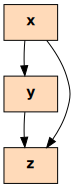

In [123]:
# ignore
_test_data.dependencies().graph()

### Control Dependencies

Let us now switch over to control dependencies. As discussed above, we invoke `test()` methods for all control conditions, and place the controlled blocks into `with` clauses.

The `test()` method simply sets a `<test>` variable; this also places it in `last_read`.

In [124]:
class DependencyTracker(DependencyTracker):
    TEST = '<test>'

    def test(self, value):
        self.set(self.TEST, value)
        return super().test(value)

When entering a `with` block, the set of `last_read` variables holds the `<test>` variable read. We save it in the `control` stack, with the effect of any further variables written now being marked as  controlled by `<test>`.

In [125]:
class DependencyTracker(DependencyTracker):
    def __enter__(self):
        self.control.append(self.last_read)
        self.clear_read()
        super().__enter__()

When we exit the `with` block, we restore earlier `last_read` values, preparing for `else` blocks.

In [126]:
class DependencyTracker(DependencyTracker):
    def __exit__(self, exc_type, exc_value, traceback):
        self.clear_read()
        self.last_read = self.control.pop()
        self.ignore_next_location_change()
        super().__exit__(exc_type, exc_value, traceback)

Here's an example of all these parts in action:

In [127]:
_test_data = DependencyTracker()
x = _test_data.set('x', 1)
y = _test_data.set('y', _test_data.get('x', x))

In [128]:
if _test_data.test(_test_data.get('x', x) >= _test_data.get('y', y)):
    with _test_data:
        z = _test_data.set('z',
                           _test_data.get('x', x) + _test_data.get('y', y))

In [129]:
_test_data.control_dependencies

{('x', ('<ipython-input-127-f0b6e1574f1c>', 2)): set(),
 ('y', ('<ipython-input-127-f0b6e1574f1c>', 3)): set(),
 ('<test>', ('<ipython-input-128-9dbb328efb5b>', 1)): set(),
 ('z',
  ('<ipython-input-128-9dbb328efb5b>', 4)): {('<test>',
   ('<ipython-input-128-9dbb328efb5b>', 1))}}

The control dependency for `z` is reflected in the dependency graph:

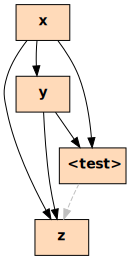

In [130]:
# ignore
_test_data.dependencies().graph()

### Calls and Returns

To handle complex expressions involving functions, we introduce a _data stack_. Every time we invoke a function `func` (`call()` is invoked), we save the list of current variables read `last_read` on the `data` stack; when we return (`ret()` is invoked), we restore `last_read`. This also ensures that only those variables read while evaluating arguments will flow into the function call.

In [131]:
class DependencyTracker(DependencyTracker):
    def call(self, fun):
        # Save context
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"saving read variables {self.last_read}")

        self.data.append(self.last_read)
        self.clear_read()
        self.ignore_next_location_change()

        return super().call(fun)

    def ret(self, value):
        super().ret(value)

        # Restore old context and add return value
        ret_name = None
        for var in self.last_read:
            if var.startswith("<"):  # "<return value>"
                ret_name = var

        self.last_read = self.data.pop()
        if ret_name is not None:
            self.last_read.append(ret_name)
        self.ignore_location_change()

        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"restored read variables {self.last_read}")

        return value

We see an example of how these work in conjunction with function arguments, discussed in the next section.

### Function Arguments

Finally, we handle parameters and arguments. The `args` stack holds the current stack of function arguments, holding the `last_read` variable for each argument. When accessing the arguments (with `param()`), we can retrieve this set of read variables for each argument.

In [132]:
class DependencyTracker(DependencyTracker):
    def arg(self, value):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"saving arg reads {self.last_read}")

        self.args.append(self.last_read)
        self.clear_read()
        return super().arg(value)

    def param(self, name, value):
        self.clear_read()
        if self.args:
            self.last_read = self.args.pop()
            self.ignore_location_change()

        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"restored param {self.last_read}")

        return super().param(name, value)

Let us illustrate all these on a small example.

In [133]:
def call_test():
    def just_x(x, y):
        return x

    a = 42
    b = 47
    return just_x(a, b)

We apply all our transformers on this code:

In [134]:
call_tree = ast.parse(inspect.getsource(call_test))
TrackCallTransformer().visit(call_tree)
TrackSetTransformer().visit(call_tree)
TrackGetTransformer().visit(call_tree)
TrackControlTransformer().visit(call_tree)
TrackReturnTransformer().visit(call_tree)
TrackParamsTransformer().visit(call_tree)
dump_tree(call_tree)

def call_test():

    def just_x(x, y):
        _data.param('y', y)
        _data.param('x', x)
        return _data.set('<just_x() return value>', _data.get('x', x))
    a = _data.set('a', 42)
    b = _data.set('b', 47)
    return _data.set('<call_test() return value>', _data.ret(_data.call(
        _data.get('just_x', just_x))(_data.arg(_data.get('a', a)), _data.
        arg(_data.get('b', b)))))



Again, we capture the dependencies:

In [135]:
class DependencyTrackerTester(DataTrackerTester):
    def make_data_tracker(self):
        return DependencyTracker(log=self.log)

In [136]:
with DependencyTrackerTester(call_tree, call_test, log=False) as deps:
    call_test()

We see how `a` and `b` properly flow into `x`, and `y`, respectively, and that only `x` flows into the return value of `just_x()`.

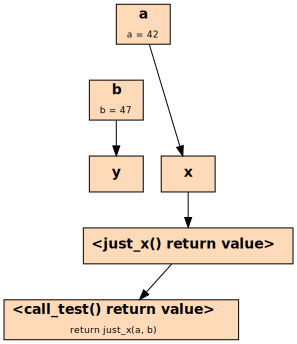

In [137]:
deps.dependencies().graph()

(Note that the Python `inspect` module cannot get the source code of "inner" functions such as `just_x()`; hence, the variables and return values of `just_x()` are listed without locations.)

### Diagnostics

To check the dependencies we obtain, we perform some minimal checks on whether a referenced variable actually also occurs in the source code.

In [138]:
import re
import sys

In [139]:
class Dependencies(Dependencies):
    def validate(self):
        super().validate()

        for var in self.all_vars():
            source = self.source(var)
            if not source:
                continue

            for dep_var in self.data[var] | self.control[var]:
                dep_name, dep_location = dep_var

                if dep_name == DependencyTracker.TEST:
                    continue

                if dep_name.endswith('return value>'):
                    if source.find('(') < 0:
                        print(f"Warning: {self.format_var(var)} "
                              f"depends on {self.format_var(dep_var)}, "
                              f"but {repr(source)} does not "
                              f"seem to have a call",
                              file=sys.stderr
                             )
                    continue

                if source.startswith('def'):
                    continue   # function call

                rx = re.compile(r'\b' + dep_name + r'\b')
                if rx.search(source) is None:
                    print(f"Warning: {self.format_var(var)} "
                          f"depends on {self.format_var(dep_var)}, "
                          f"but {repr(dep_name)} does not occur "
                          f"in {repr(source)}",
                          file=sys.stderr
                         )

## Slicing Code

Let us now put all these pieces together. We have a means to instrument the source code (our various `NodeTransformer` classes) and a means to track dependencies (the `DependencyTracker` class).

TODO: Discuss things.

In [140]:
class Instrumenter(object):
    def __init__(self, *items_to_instrument, log=False):
        self.log = log
        self.items_to_instrument = items_to_instrument

    def __enter__(self):
        """Instrument sources"""
        for item in self.items_to_instrument:
            self.instrument(item)
        return self

    def instrument(self, item):
        if self.log:
            print("Instrumenting", item)

In [141]:
class Instrumenter(Instrumenter):
    def __exit__(self, exc_type, exc_value, traceback):
        """Restore sources"""
        self.restore()

    def restore(self):
        for item in self.items_to_instrument:
            globals()[item.__name__] = item

In [142]:
with Instrumenter(middle) as ins:
    pass

In [143]:
class Slicer(Instrumenter):
    def __init__(self, *items_to_instrument, 
                 dependency_tracker=None,
                 log=False):
        super().__init__(*items_to_instrument, log=log)
        if len(items_to_instrument) == 0:
            raise ValueError("Need one or more items to instrument")

        if dependency_tracker is None:
            dependency_tracker = DependencyTracker(log=(log > 1))
        self.dependency_tracker = dependency_tracker
        self.saved_dependencies = None

In [144]:
class Slicer(Slicer):
    def transformers(self):
        """List of transformers to apply. To be extended in subclasses."""
        return [
            TrackCallTransformer(),
            TrackSetTransformer(),
            TrackGetTransformer(),
            TrackControlTransformer(),
            TrackReturnTransformer(),
            TrackParamsTransformer()
        ]

    def instrument(self, item):
        """Instrument ITEM, transforming its source code using."""
        source_lines, lineno = inspect.getsourcelines(item)
        tree = ast.parse("".join(source_lines))
        ast.increment_lineno(tree, lineno - 1)

        if self.log:
            print(f"Instrumenting {item}:")

            if self.log >= 2:
                n = lineno
                for line in source_lines:
                    print(f"{n:4} {line.rstrip()}")
                    n += 1
                print()

        for transformer in self.transformers():
            if self.log >= 3:
                print(transformer.__class__.__name__ + ':')

            transformer.visit(tree)
            ast.fix_missing_locations(tree)
            if self.log >= 3:
                print(astor.to_source(tree))

        if self.log:
            print(astor.to_source(tree))

        code = compile(tree, '<string>', 'exec')
        exec(code, globals())
        globals()[DATA_TRACKER] = self.dependency_tracker

    def restore(self):
        """Restore original code."""
        if DATA_TRACKER in globals():
            self.saved_dependencies = globals()[DATA_TRACKER]
            del globals()[DATA_TRACKER]
        super().restore()

In [145]:
class Slicer(Slicer):
    def dependencies(self):
        if self.saved_dependencies is None:
            return Dependencies({}, {})
        return self.saved_dependencies.dependencies()

    def code(self, *args, **kwargs):
        first = True
        for item in self.items_to_instrument:
            if not first:
                print()
            self.dependencies().code(item, *args, **kwargs)
            first = False

    def graph(self, *args, **kwargs):
        return self.dependencies().graph(*args, **kwargs)

In [146]:
with Slicer(middle) as slicer:
    m = middle(2, 1, 3)
m

1

In [147]:
print(slicer.dependencies())

middle():
    <test> (2) <= z (1), y (1)
    <test> (3) <= x (1), y (1); <- <test> (2)
    <test> (5) <= x (1), z (1); <- <test> (3)
    <middle() return value> (6) <= y (1); <- <test> (5)



In [148]:
slicer.dependencies()

Dependencies({('z', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('x', ('middle', 1)): set(), ('<test>', ('middle', 2)): {('z', ('middle', 1)), ('y', ('middle', 1))}, ('<test>', ('middle', 3)): {('x', ('middle', 1)), ('y', ('middle', 1))}, ('<test>', ('middle', 5)): {('x', ('middle', 1)), ('z', ('middle', 1))}, ('<middle() return value>', ('middle', 6)): {('y', ('middle', 1))}}, {('z', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('x', ('middle', 1)): set(), ('<test>', ('middle', 2)): set(), ('<test>', ('middle', 3)): {('<test>', ('middle', 2))}, ('<test>', ('middle', 5)): {('<test>', ('middle', 3))}, ('<middle() return value>', ('middle', 6)): {('<test>', ('middle', 5))}})

In [149]:
slicer.code()

*    1 def middle(x, y, z):
*    2     if y < z:  # <= z (1), y (1)
*    3         if x < y:  # <= x (1), y (1); <- <test> (2)
     4             return y
*    5         elif x < z:  # <= x (1), z (1); <- <test> (3)
*    6             return y  # <= y (1); <- <test> (5)
     7     else:
     8         if x > y:
     9             return y
    10         elif x > z:
    11             return x
    12     return z


In [150]:
middle(2, 1, 3)

1

In [151]:
with Slicer(middle) as middle_slicer:
    y = middle(2, 1, 3)

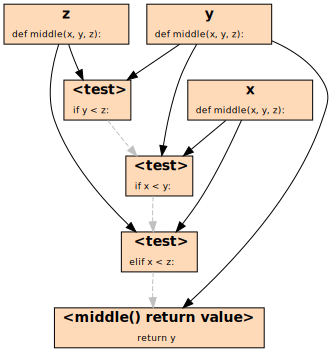

In [152]:
middle_slicer.graph()

In [153]:
print(middle_slicer.dependencies())

middle():
    <test> (2) <= z (1), y (1)
    <test> (3) <= x (1), y (1); <- <test> (2)
    <test> (5) <= x (1), z (1); <- <test> (3)
    <middle() return value> (6) <= y (1); <- <test> (5)



## More Examples

In [154]:
import math

In [155]:
def f():
    math.isclose

In [156]:
with Slicer(f, log=2) as f_slicer:
    f()

Instrumenting <function f at 0x7fbb1d5492f0>:
   1 def f():
   2     math.isclose

def f():
    _data.get('math', math).isclose

f:2: clearing read variables [] (from check_location)
f:2: getting math


In [157]:
from Assertions import square_root

In [158]:
with Slicer(square_root, log=True) as root_slicer:
    y = square_root(2.0)

Instrumenting <function square_root at 0x7fbb1d50fa60>:
def square_root(x):
    _data.param('x', x)
    assert _data.get('x', x) >= 0
    approx = _data.set('approx', None)
    guess = _data.set('guess', _data.get('x', x) / 2)
    while _data.test(_data.get('approx', approx) != _data.get('guess', guess)):
        with _data:
            approx = _data.set('approx', _data.get('guess', guess))
            guess = _data.set('guess', (_data.get('approx', approx) + _data
                .get('x', x) / _data.get('approx', approx)) / 2)
    assert _data.ret(_data.call(_data.get('math', math).isclose)(_data.arg(
        _data.get('approx', approx) * _data.get('approx', approx)), _data.
        arg(_data.get('x', x))))
    return _data.set('<square_root() return value>', _data.get('approx',
        approx))



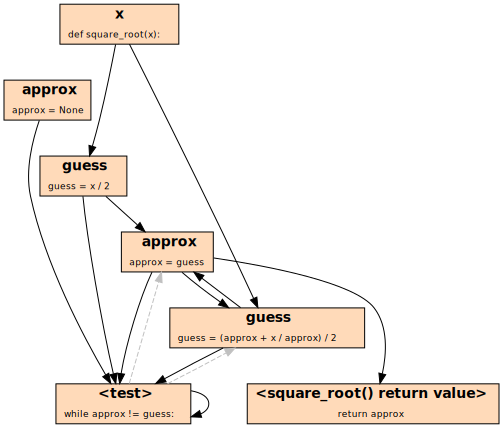

In [159]:
root_slicer.graph()

FIXME: How does `<test>` control itself? (Because it's a `while` loop)

In [160]:
root_slicer.code()

*   51 def square_root(x):
    52     assert x >= 0  # precondition
    53 
*   54     approx = None
*   55     guess = x / 2  # <= x (51)
*   56     while approx != guess:  # <= approx (54), guess (55), approx (57), guess (58), <test> (56)
*   57         approx = guess  # <= guess (55), guess (58); <- <test> (56)
*   58         guess = (approx + x / approx) / 2  # <= x (51), approx (57); <- <test> (56)
    59 
    60     assert math.isclose(approx * approx, x)
*   61     return approx  # <= approx (57)


In [161]:
root_slicer.dependencies()

Dependencies({('x', ('square_root', 51)): set(), ('approx', ('square_root', 54)): set(), ('guess', ('square_root', 55)): {('x', ('square_root', 51))}, ('<test>', ('square_root', 56)): {('approx', ('square_root', 54)), ('guess', ('square_root', 55)), ('approx', ('square_root', 57)), ('guess', ('square_root', 58)), ('<test>', ('square_root', 56))}, ('approx', ('square_root', 57)): {('guess', ('square_root', 55)), ('guess', ('square_root', 58))}, ('guess', ('square_root', 58)): {('x', ('square_root', 51)), ('approx', ('square_root', 57))}, ('<square_root() return value>', ('square_root', 61)): {('approx', ('square_root', 57))}}, {('x', ('square_root', 51)): set(), ('approx', ('square_root', 54)): set(), ('guess', ('square_root', 55)): set(), ('<test>', ('square_root', 56)): set(), ('approx', ('square_root', 57)): {('<test>', ('square_root', 56))}, ('guess', ('square_root', 58)): {('<test>', ('square_root', 56))}, ('<square_root() return value>', ('square_root', 61)): set()})

In [162]:
from Intro_Debugging import remove_html_markup

In [163]:
with Slicer(remove_html_markup, log=True) as rhm_slicer:
    s = remove_html_markup("<foo>bar</foo>")

Instrumenting <function remove_html_markup at 0x7fbb1d549d90>:
def remove_html_markup(s):
    _data.param('s', s)
    tag = _data.set('tag', False)
    quote = _data.set('quote', False)
    out = _data.set('out', '')
    for c in _data.set('c', _data.get('s', s)):
        assert _data.get('tag', tag) or not _data.get('quote', quote)
        if _data.test(_data.get('c', c) == '<' and not _data.get('quote',
            quote)):
            with _data:
                tag = _data.set('tag', True)
        else:
            with _data:
                if _data.test(_data.get('c', c) == '>' and not _data.get(
                    'quote', quote)):
                    with _data:
                        tag = _data.set('tag', False)
                else:
                    with _data:
                        if _data.test((_data.get('c', c) == '"' or _data.
                            get('c', c) == "'") and _data.get('tag', tag)):
                            with _data:
                     

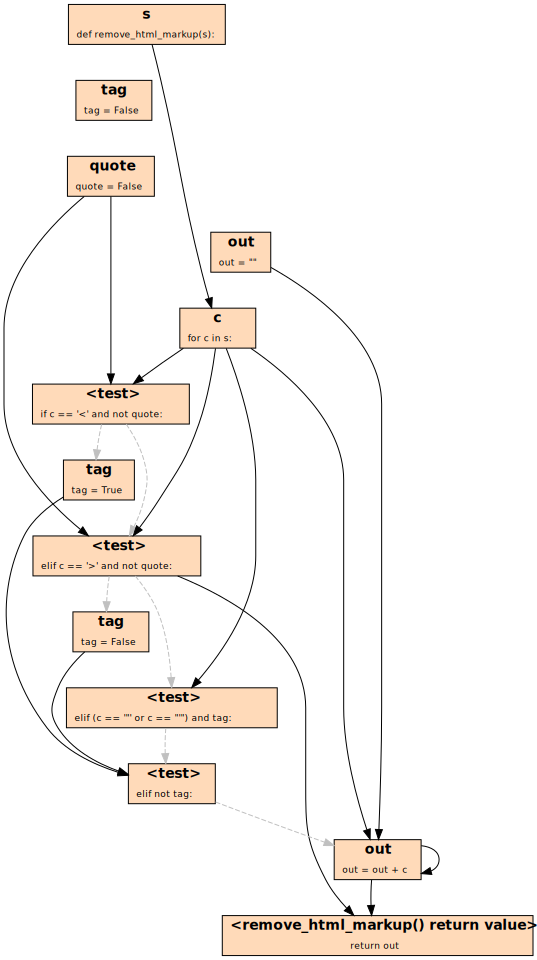

In [164]:
rhm_slicer.graph()

In [165]:
rhm_slicer.code()

*  136 def remove_html_markup(s):
*  137     tag = False
*  138     quote = False
*  139     out = ""
   140 
*  141     for c in s:  # <= s (136)
   142         assert tag or not quote
   143 
*  144         if c == '<' and not quote:  # <= quote (138), c (141)
*  145             tag = True  # <- <test> (144)
*  146         elif c == '>' and not quote:  # <= quote (138), c (141); <- <test> (144)
*  147             tag = False  # <- <test> (146)
*  148         elif (c == '"' or c == "'") and tag:  # <= c (141); <- <test> (146)
   149             quote = not quote
*  150         elif not tag:  # <= tag (147), tag (145); <- <test> (148)
*  151             out = out + c  # <= out (151), c (141), out (139); <- <test> (150)
   152 
*  153     return out  # <= out (151), <test> (146)


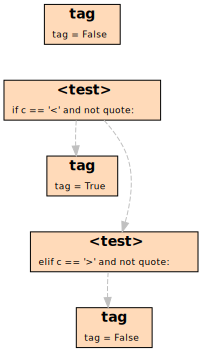

In [166]:
rhm_slicer.dependencies().backward_slice('tag', mode='c').graph()

In [167]:
def add_to(n, m):
    n += m
    return n

In [168]:
def mul_with(x, y):
    x *= y
    return x

In [169]:
def test_math():
    return mul_with(1, add_to(2, 2))

In [170]:
with Slicer(add_to, mul_with, test_math) as math_slicer:
    test_math()

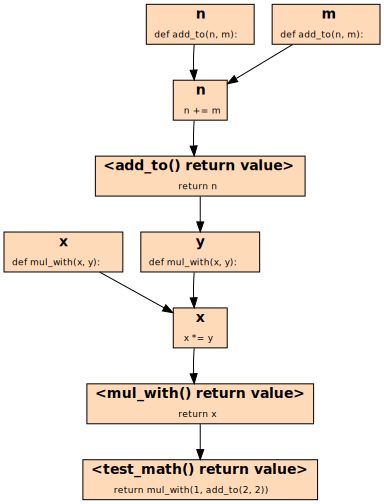

In [171]:
math_slicer.graph()

In [172]:
math_slicer.code()

*    1 def add_to(n, m):
*    2     n += m  # <= m (1), n (1)
*    3     return n  # <= n (2)

*    1 def mul_with(x, y):  # <= <add_to() return value> (add_to:3)
*    2     x *= y  # <= y (1), x (1)
*    3     return x  # <= x (2)

     1 def test_math():
*    2     return mul_with(1, add_to(2, 2))  # <= <mul_with() return value> (mul_with:3)


In [173]:
print(math_slicer.dependencies())

mul_with():
    y (1) <= <add_to() return value> (add_to:3)
    x (2) <= y (1), x (1)
    <mul_with() return value> (3) <= x (2)

test_math():
    <test_math() return value> (2) <= <mul_with() return value> (mul_with:3)

add_to():
    n (2) <= m (1), n (1)
    <add_to() return value> (3) <= n (2)



## Things that do not Work

### Data Structures

In [174]:
def test_array():
    x = [1, 2, 3]
    y = 4
    x[2] = y
    return x[2]

In [175]:
with Slicer(test_array, log=True) as array_slicer:
    test_array()

Instrumenting <function test_array at 0x7fbb1d5760d0>:
def test_array():
    x = _data.set('x', [1, 2, 3])
    y = _data.set('y', 4)
    _data.get('x', x)[2] = _data.set('x[2]', _data.get('y', y))
    return _data.set('<test_array() return value>', _data.get('x', x)[2])



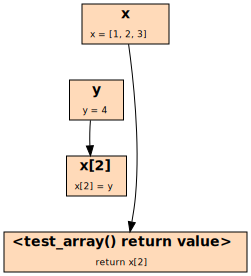

In [176]:
array_slicer.graph()

### Attributes

In [177]:
class X(object):
    pass

In [178]:
def test_attributes(y):
    x = X()
    x.attr = y
    return x.attr

In [179]:
with Slicer(test_attributes, log=True) as attr_slicer:
    test_attributes(10)

Instrumenting <function test_attributes at 0x7fbb1d576158>:
def test_attributes(y):
    _data.param('y', y)
    x = _data.ret(_data.call(_data.get('X', X))())
    _data.get('x', x).attr = _data.set('x.attr', _data.get('y', y))
    return _data.set('<test_attributes() return value>', _data.get('x', x).attr
        )



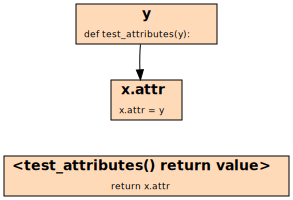

In [180]:
attr_slicer.graph()

TODO: Auto-slice things – in 

```python
with Slicer():
   foo()
```
identify all calls in the code and add them to the instrumentation.

1. Get source code - won't work; will not contain body
2. Use a decorator? (works only for functions...)
3. Replace on the fly – won't work (or will it?), as we cannot change code once it executes

In [181]:
from ExpectError import ExpectError

In [182]:
with ExpectError():
    with Slicer() as slicer:
        y = square_root(9)

Traceback (most recent call last):
  File "<ipython-input-182-04fc5ccbc736>", line 2, in <module>
    with Slicer() as slicer:
  File "<ipython-input-143-e3781941df31>", line 7, in __init__
    raise ValueError("Need one or more items to instrument")
ValueError: Need one or more items to instrument (expected)


TODO: Create a probabilistic dependence graph for statistical debugging :-)

## Synopsis

_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

@INPROCEEDINGS{6899220,
  author={Z. {Chen} and L. {Chen} and Y. {Zhou} and Z. {Xu} and W. C. {Chu} and B. {Xu}},
  booktitle={2014 IEEE 38th Annual Computer Software and Applications Conference}, 
  title={Dynamic Slicing of Python Programs}, 
  year={2014},
  volume={},
  number={},
  pages={219-228},
  doi={10.1109/COMPSAC.2014.30}
}



## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [183]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [184]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_